<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_merge_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [1]:
# install emoji library
!pip install emot

     |████████████████████████████████| 61 kB 18 kB/s 


In [2]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Please install GPU version of TF
True
2.8.0
2.8.0


In [4]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load software data

In [5]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [6]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


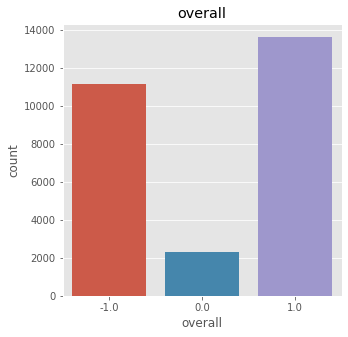

In [7]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


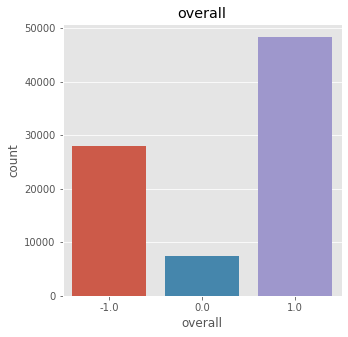

In [8]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


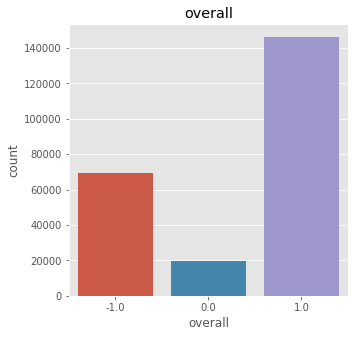

In [9]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


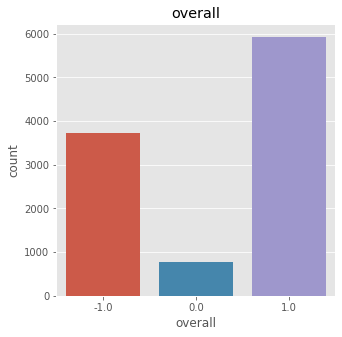

In [10]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5900 positive，3700 negative，770 neutral

80%(8056) training and 20%(2314) testing

In [11]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4480,:]
  train_neudata = neu.iloc[:616,:]
  train_negdata = neg.iloc[:2960,:]

  # split to get test for each class
  test_posdata = pos.iloc[4480:5900,:]
  test_neudata = neu.iloc[616:770,:]
  test_negdata = neg.iloc[2960:3700,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [12]:
# data for 1998 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [13]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [14]:
df4_train.head()

,overall,reviewTime,reviewText
5387,1.0,2018,Good deal!
220,1.0,2018,Great product and protects and cleans my compu...
8026,1.0,2018,I am much older now but I happen to remember t...
7020,1.0,2018,This game is one of my favorites! The disc arr...
1884,2.0,2018,Well what can I say? Malwarebytes and their cu...


## Text Preprocessing

In [15]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [16]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [17]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [18]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [19]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
4979,2.0,2003,"I purchased NIS on May 31, 2003 and returned i...",purchased nis may returned week later removed ...
12567,1.0,2005,"I am very pleased, so far, with this software....",pleased far software finding user friendly
13186,1.0,2006,Yes this is a Microsoft V1 SP1 product (don't ...,yes microsoft sp product dont forget download ...
19300,1.0,2001,"Even if you are new to the 3d software Genre, ...",even new software genre really good program st...
25576,2.0,2006,I ordered this product in Dec. of 2005. When I...,ordered product dec finally received came corr...


In [20]:
df4_test.head()

,overall,reviewTime,reviewText,cleanText
624,1.0,2018,"Since purchasing this course, I have discovere...",purchasing course discovered many free lessons...
1186,1.0,2018,"I love it. There is never an interruption, t...",love never interruption sound comes device cho...
2202,1.0,2018,I used this when I had a really bad accident a...,used really bad accident couldnt use hands got...
870,2.0,2018,I used to really like this app. Since I had p...,used really like app purchased music amazon co...
7580,1.0,2018,"I wasn't sure if my son would like this, but h...",wasnt sure son like needs learn typing middle ...


## Merge train&test data

Extract 25% data from each time period and combine train&test

In [27]:
def merge(df1,df2,df3,df4,rate):
  sample1 = df1.sample(frac=rate,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample4 = df4.sample(frac=rate,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3, sample4],sort=False).sample(frac=1.0)

  return merged

In [28]:
train_merged = merge(df1_train,df2_train,df3_train,df4_train,0.25)
test_merged = merge(df1_test,df2_test,df3_test,df4_test,0.25)

In [29]:
train_merged.shape

(8056, 4)

In [30]:
test_merged.shape

(2312, 4)

## Text Tokenization

In [31]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

29844 words are used
Training:
Average length of each row >> 68.45655412115194
Maximum length of each row >> 1610


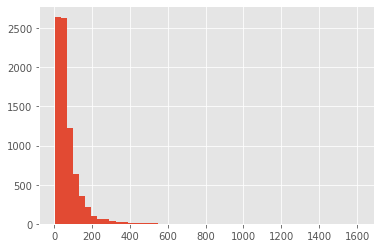

Testing
Average length of each row >> 63.74935177182368
Maximum length of each row >> 490


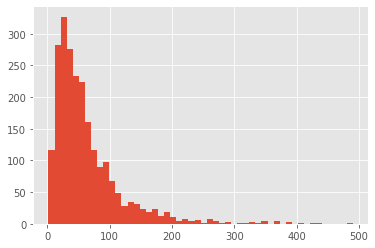

max sequence length:  1610


In [32]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

24048 words are used
Training:
Average length of each row >> 55.79083912611718
Maximum length of each row >> 1376


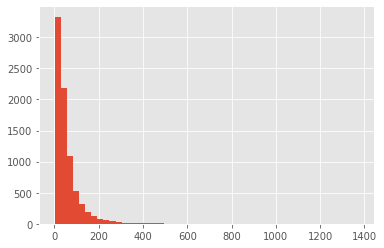

Testing
Average length of each row >> 52.97925669835782
Maximum length of each row >> 951


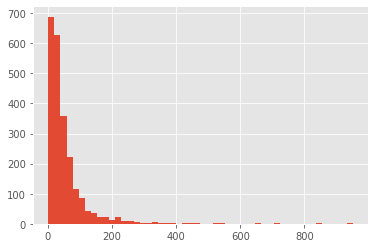

max sequence length:  1376


In [33]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

14906 words are used
Training:
Average length of each row >> 26.93458291956306
Maximum length of each row >> 841


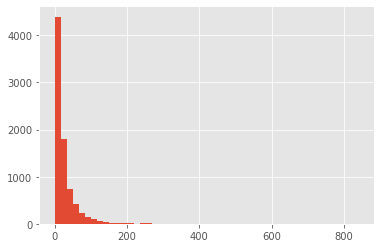

Testing
Average length of each row >> 26.261019878997406
Maximum length of each row >> 789


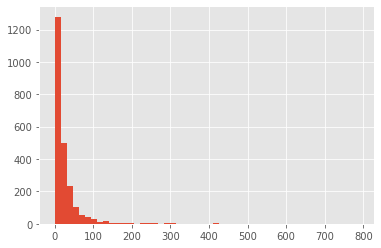

max sequence length:  841


In [34]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

11813 words are used
Training:
Average length of each row >> 17.255089374379345
Maximum length of each row >> 477


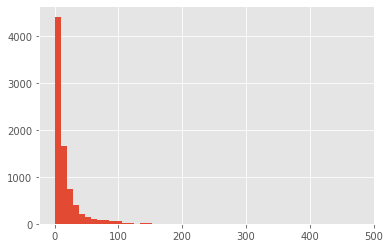

Testing
Average length of each row >> 14.492221261884183
Maximum length of each row >> 321


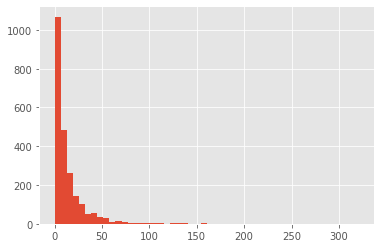

max sequence length:  477


In [35]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

21201 words are used
Training:
Average length of each row >> 41.90367428003972
Maximum length of each row >> 1610


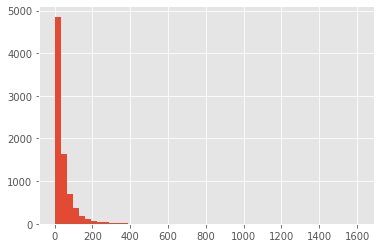

Testing
Average length of each row >> 37.694636678200695
Maximum length of each row >> 949


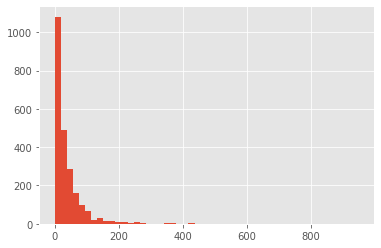

max sequence length:  1610


In [36]:
merge_train_fea,merge_test_fea,merge_vocab_size,merge_maxlen = tokenize(train_merged["cleanText"],test_merged["cleanText"])

## Padding

In [37]:
sequence_size = max(df1_maxlen,df2_maxlen,df3_maxlen,df4_maxlen,merge_maxlen)
print("max sequence length for software: ",sequence_size)

max sequence length for software:  1610


In [38]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

merge_train_pad = pad_sequences(merge_train_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad = pad_sequences(merge_test_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label = to_categorical(train_merged.overall,num_classes=3)
merge_test_label = to_categorical(test_merged.overall,num_classes=3)

## Build LSTM Model and Train on merged train

In [40]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size,merge_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  29844


In [41]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [42]:
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [43]:
bilstm = bilstm_model()
plot_model(bilstm)
lstm_no_hist = bilstm.fit(merge_train_pad,merge_train_label,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad,merge_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1610, 100)         2984400   
                                                                 
 bidirectional (Bidirectiona  (None, 1610, 256)        234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 412160)            0         
                                                                 
 dense (Dense)               (None, 32)                13189152  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

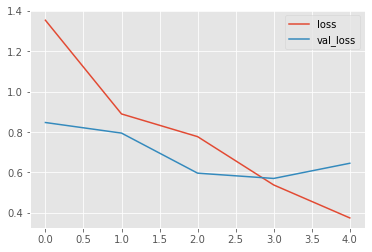

In [44]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

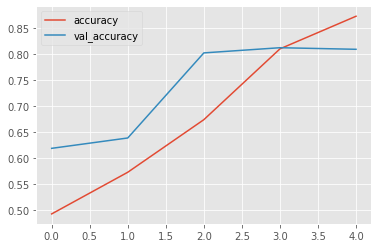

In [45]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [46]:
bilstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')

## Evaluate on each time period data

In [48]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 85s 1s/step - loss: 1.6956 - accuracy: 0.4607


[1.6956309080123901, 0.4606741666793823]

In [49]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 56s 731ms/step - loss: 1.4950 - accuracy: 0.4939


[1.4949816465377808, 0.49394986033439636]

In [50]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 63s 835ms/step - loss: 1.2394 - accuracy: 0.5553


[1.2394288778305054, 0.5553154945373535]

In [51]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df4_test_pad,df4_test_label)

73/73 [==============================] - 58s 753ms/step - loss: 1.2323 - accuracy: 0.5743


[1.2323040962219238, 0.5743301510810852]

## Fine tune on 1998-2006

13669 words are used
Training:
Average length of each row >> 67.24875868917577
Maximum length of each row >> 1610


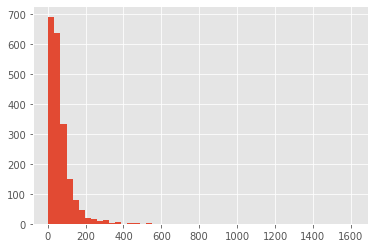

Testing
Average length of each row >> 60.69723183391003
Maximum length of each row >> 474


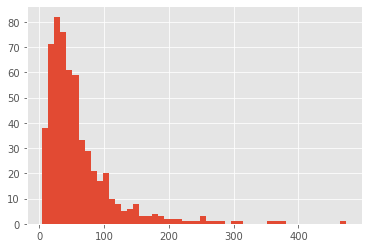

max sequence length:  1610


In [52]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')

df1_sample_train = df1_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df1_sample_test = df1_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df1_sample_train_fea,df1_sample_test_fea,df1_sample_vocab_size,df1_sample_maxlen = tokenize(df1_sample_train["cleanText"],df1_sample_test["cleanText"])

In [54]:
df1_sample_train_pad = pad_sequences(df1_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_sample_test_pad = pad_sequences(df1_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_sample_train_label = to_categorical(df1_sample_train.overall,num_classes=3)
df1_sample_test_label = to_categorical(df1_sample_test.overall,num_classes=3)

In [55]:
merged_lstm.fit(df1_sample_train_pad,df1_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_sample_test_pad,df1_sample_test_label),callbacks=[es])

Epoch 1/8
8/8 [==============================] - 215s 22s/step - loss: 1.1254 - accuracy: 0.4806 - val_loss: 0.8935 - val_accuracy: 0.6194
Epoch 2/8
8/8 [==============================] - 176s 22s/step - loss: 0.9597 - accuracy: 0.5020 - val_loss: 0.8930 - val_accuracy: 0.6280
Epoch 3/8
8/8 [==============================] - 176s 22s/step - loss: 0.9185 - accuracy: 0.5040 - val_loss: 0.8867 - val_accuracy: 0.5363
Epoch 4/8
8/8 [==============================] - 191s 24s/step - loss: 0.8879 - accuracy: 0.5467 - val_loss: 0.8416 - val_accuracy: 0.6661
Epoch 5/8
8/8 [==============================] - 177s 22s/step - loss: 0.8584 - accuracy: 0.5670 - val_loss: 0.8365 - val_accuracy: 0.6696
Epoch 6/8
8/8 [==============================] - 174s 22s/step - loss: 0.7910 - accuracy: 0.5914 - val_loss: 0.7912 - val_accuracy: 0.6886
Epoch 7/8
8/8 [==============================] - 185s 24s/step - loss: 0.7445 - accuracy: 0.5899 - val_loss: 0.7618 - val_accuracy: 0.7059
Epoch 7: early stopping


## Fine tune on 2007-2012

11607 words are used
Training:
Average length of each row >> 57.34856007944389
Maximum length of each row >> 662


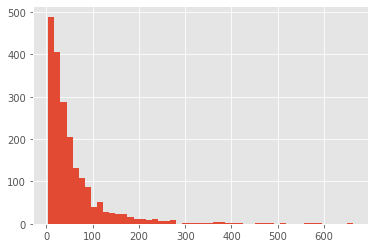

Testing
Average length of each row >> 50.03114186851211
Maximum length of each row >> 507


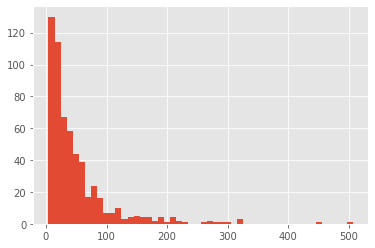

max sequence length:  662


In [58]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')

df2_sample_train = df2_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df2_sample_test = df2_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df2_sample_train_fea,df2_sample_test_fea,df2_sample_vocab_size,df2_sample_maxlen = tokenize(df2_sample_train["cleanText"],df2_sample_test["cleanText"])

In [59]:
df2_sample_train_pad = pad_sequences(df2_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_sample_test_pad = pad_sequences(df2_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_sample_train_label = to_categorical(df2_sample_train.overall,num_classes=3)
df2_sample_test_label = to_categorical(df2_sample_test.overall,num_classes=3)

In [60]:
merged_lstm.fit(df2_sample_train_pad,df2_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_sample_test_pad,df2_sample_test_label),callbacks=[es])

Epoch 1/8
8/8 [==============================] - 185s 21s/step - loss: 1.1203 - accuracy: 0.4955 - val_loss: 0.9373 - val_accuracy: 0.5952
Epoch 2/8
8/8 [==============================] - 170s 21s/step - loss: 0.9574 - accuracy: 0.5015 - val_loss: 0.8723 - val_accuracy: 0.6125
Epoch 3/8
8/8 [==============================] - 168s 21s/step - loss: 0.9268 - accuracy: 0.5089 - val_loss: 0.8579 - val_accuracy: 0.5969
Epoch 4/8
8/8 [==============================] - 178s 23s/step - loss: 0.9124 - accuracy: 0.4970 - val_loss: 0.8545 - val_accuracy: 0.6003
Epoch 5/8
8/8 [==============================] - 167s 21s/step - loss: 0.8944 - accuracy: 0.5079 - val_loss: 0.8407 - val_accuracy: 0.6021
Epoch 5: early stopping


## Fine tune on 2013-2017

7356 words are used
Training:
Average length of each row >> 28.297418073485602
Maximum length of each row >> 748


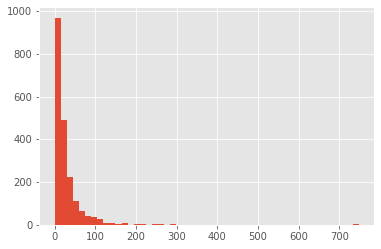

Testing
Average length of each row >> 25.455017301038062
Maximum length of each row >> 743


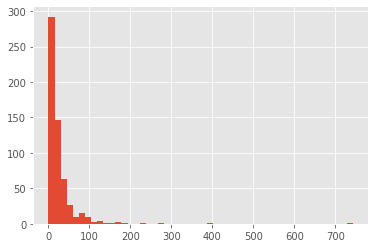

max sequence length:  748


In [63]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')

df3_sample_train = df3_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df3_sample_test = df3_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df3_sample_train_fea,df3_sample_test_fea,df3_sample_vocab_size,df3_sample_maxlen = tokenize(df3_sample_train["cleanText"],df3_sample_test["cleanText"])

In [64]:
df3_sample_train_pad = pad_sequences(df3_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_sample_test_pad = pad_sequences(df3_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_sample_train_label = to_categorical(df3_sample_train.overall,num_classes=3)
df3_sample_test_label = to_categorical(df3_sample_test.overall,num_classes=3)

In [65]:
merged_lstm.fit(df3_sample_train_pad,df3_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_sample_test_pad,df3_sample_test_label),callbacks=[es])

Epoch 1/8
8/8 [==============================] - 193s 24s/step - loss: 1.1200 - accuracy: 0.5010 - val_loss: 0.8937 - val_accuracy: 0.6125
Epoch 2/8
8/8 [==============================] - 202s 26s/step - loss: 0.9319 - accuracy: 0.5204 - val_loss: 0.8830 - val_accuracy: 0.6142
Epoch 3/8
8/8 [==============================] - 171s 22s/step - loss: 0.9249 - accuracy: 0.5089 - val_loss: 0.8880 - val_accuracy: 0.6176
Epoch 4/8
8/8 [==============================] - 171s 22s/step - loss: 0.9263 - accuracy: 0.5025 - val_loss: 0.9379 - val_accuracy: 0.6592
Epoch 5/8
8/8 [==============================] - 180s 23s/step - loss: 0.9281 - accuracy: 0.4940 - val_loss: 0.8769 - val_accuracy: 0.6505
Epoch 5: early stopping


## Fine tune on 2018

5575 words are used
Training:
Average length of each row >> 17.33614697120159
Maximum length of each row >> 282


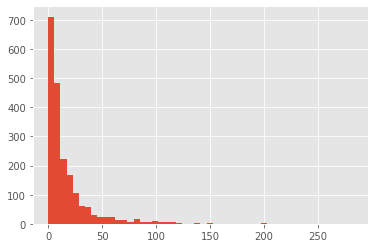

Testing
Average length of each row >> 13.088235294117647
Maximum length of each row >> 151


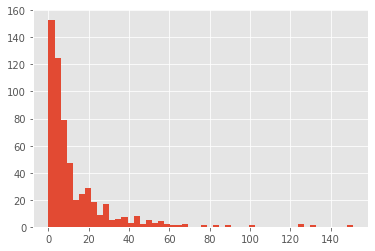

max sequence length:  282


In [66]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge.h5')

df4_sample_train = df4_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df4_sample_test = df4_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df4_sample_train_fea,df4_sample_test_fea,df4_sample_vocab_size,df4_sample_maxlen = tokenize(df4_sample_train["cleanText"],df4_sample_test["cleanText"])

In [67]:
df4_sample_train_pad = pad_sequences(df4_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_sample_test_pad = pad_sequences(df4_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_sample_train_label = to_categorical(df4_sample_train.overall,num_classes=3)
df4_sample_test_label = to_categorical(df4_sample_test.overall,num_classes=3)

In [68]:
merged_lstm.fit(df4_sample_train_pad,df4_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df4_sample_test_pad,df4_sample_test_label),callbacks=[es])

Epoch 1/8
8/8 [==============================] - 188s 23s/step - loss: 1.1060 - accuracy: 0.4955 - val_loss: 1.0255 - val_accuracy: 0.6021
Epoch 2/8
8/8 [==============================] - 174s 22s/step - loss: 1.0076 - accuracy: 0.4930 - val_loss: 1.0029 - val_accuracy: 0.6332
Epoch 3/8
8/8 [==============================] - 181s 22s/step - loss: 0.9719 - accuracy: 0.5184 - val_loss: 0.8863 - val_accuracy: 0.3149
Epoch 4/8
8/8 [==============================] - 177s 22s/step - loss: 0.9334 - accuracy: 0.4752 - val_loss: 0.8032 - val_accuracy: 0.6488
Epoch 5/8
8/8 [==============================] - 170s 22s/step - loss: 0.9219 - accuracy: 0.5074 - val_loss: 0.8489 - val_accuracy: 0.6488
Epoch 6/8
8/8 [==============================] - 185s 24s/step - loss: 0.9190 - accuracy: 0.5308 - val_loss: 0.8761 - val_accuracy: 0.6678
Epoch 7/8
8/8 [==============================] - 170s 22s/step - loss: 0.9075 - accuracy: 0.5665 - val_loss: 0.8197 - val_accuracy: 0.6644
Epoch 7: early stopping
